## Churn-in-Telecom`s-dataset

https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy.stats import kurtosis, skew, shapiro, normaltest
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import auc, plot_roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

### Сделаем функцию вместо GridSearch для известных нам классификаторов и показа их метрик

In [2]:
def value_of_metrics_cv(X, y, model, title):
    sns.set_style('whitegrid')
    st_fold = StratifiedKFold(n_splits=7, shuffle=True, random_state=5)
    params = {'estimator': model, 'X': X, 'y': y, 'cv': st_fold}
    scores = cross_validate(**params, scoring=('accuracy', 'balanced_accuracy',
                                               'recall', 'precision', 'f1', 'roc_auc'))
    print('Accuracy: ', scores['test_accuracy'].mean())
    print('Balanced accuracy: ', scores['test_balanced_accuracy'].mean())
    print('Recall: ', scores['test_recall'].mean())
    print('Precision: ', scores['test_precision'].mean())
    print('F1: ', scores['test_f1'].mean())
    print('Roc_AUC: ', scores['test_roc_auc'].mean())
    conf_matrix_list_of_arrays = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    plt.close(fig)
    for i, (train, test) in enumerate(st_fold.split(X, y)):
        model.fit(X[train], y[train])
        viz = plot_roc_curve(model, X[test], y[test],
                                     name='ROC fold {}'.format(i), ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        conf_matrix = confusion_matrix(y[test], model.predict(X[test]))
        conf_matrix_list_of_arrays.append(conf_matrix)
    mean_сonf_matrix = np.round(np.mean(conf_matrix_list_of_arrays, axis=0), 0)
    print('Confusion Matrix:')
    print(pd.DataFrame(mean_сonf_matrix.astype(int)))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    roc_auc = auc(mean_fpr, mean_tpr)
    plt.title(title, y=1.01, fontsize=14)
    plt.plot(mean_fpr, mean_tpr, 'b', label = 'Mean  AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fontsize=11)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [3]:
# функция, объединяющая GridSearch нужных нам классификаторов и показ их метрик

class BestClassifier():

    def __init__(self, X_train, X_test, transformer=None):
        self.X_train = X_train
        self.y_train = y_train
        self.transformer = transformer
        
    def _make_pipeline(self, clf):
        if self.transformer is None:
            self.pipe = make_pipeline(clf)
        else:
            self.pipe = make_pipeline(self.transformer, clf)
        
    def _fit_gs_and_print_gs_results(self, gs):
        gs.fit(self.X_train, self.y_train)
        self.params = gs.best_params_
        # remove the name of estimator from parameters names
        if '__' in list(self.params.keys())[0]:
            keys_list = [key.split('__')[1] for key in list(self.params.keys())]
            self.params = dict(zip(keys_list, self.params.values()))
        print('Best score (roc_auc): {}'.format(gs.best_score_))
        print('Best parameters: {}\n'.format(self.params))
        print('С лучшими параметрами и кросс-валидацией:')
 
    def random_forest(self):
        estimator = 'randomforestclassifier__'
        self.grid = {estimator +'n_estimators': [30, 40, 50, 60, 70],
                     estimator +'criterion': ['gini', 'entropy'],
                     estimator +'max_depth': [None, 5, 6, 7, 8, 9, 10, 11],
                     estimator +'class_weight': [None, 'balanced']}
        self._make_pipeline(RandomForestClassifier())
        gs = GridSearchCV(self.pipe, self.grid, cv=5, scoring='roc_auc')
        self._fit_gs_and_print_gs_results(gs)
        self._make_pipeline(RandomForestClassifier(**self.params))
        value_of_metrics_cv(self.X_train, self.y_train,
                            self.pipe, 'Random Forest')

    def svm(self):
        estimator = 'svc__'
        self.grid = {estimator +'kernel': ['poly', 'rbf', 'sigmoid'],
                     estimator +'C': [0.5, 0.7, 1, 2, 3],
                     estimator +'degree': [1, 2, 3, 4, 5, 6],
                     estimator +'gamma': ['scale', 'auto'],
                     estimator +'class_weight': [None, 'balanced']}
        self._make_pipeline(svm.SVC())
        gs = GridSearchCV(self.pipe, self.grid, cv=5, scoring='roc_auc')
        self._fit_gs_and_print_gs_results(gs)
        self._make_pipeline(svm.SVC(**self.params))
        value_of_metrics_cv(self.X_train, self.y_train,
                            self.pipe, 'Support Vector Machine')

### Чтение из файла и первичный анализ

In [4]:
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Посмотрим на размер данных, названия признаков и их типы**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

**Кодирование категориальных признаков**

In [25]:
df['Churn'] = df['Churn'].astype('int64')
df['International plan'] = df['International plan'].map({'No':0, 'Yes':1})
df['Voice mail plan'] = df['Voice mail plan'].map({'No':0, 'Yes':1})
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Рассмотрим признак Area code:

In [26]:
print(df['Area code'].value_counts(normalize=True))
print('Корреляция:', df['Area code'].corr(df.Churn))

415    0.496550
510    0.252025
408    0.251425
Name: Area code, dtype: float64
Корреляция: 0.006174233160678263


Как мы видим, в признаке всего 3 уникальных значения, половина клиентов соответствует первому значению, а другая половина делится поровну на 2 других значения. При этом корреляция данного признака крайне мала (0.6 %). Давайте удалим этот признак, он несущественен.

In [27]:
df.drop(['Area code'], axis=1, inplace=True)

**Для работы со штатами (State) разобьем их на 4 группы, исходя из степени оттока клиентов (Churn)** <br/> Логично будет разделить штаты исходя из средних значений оттока для каждого из них, так как среднее значение Churn для штата - по сути пропорция тех, кто меняет компанию и тех, кто остается - чем число ближе к 1, тем больше отток клиентов в штате. Впоследствии мы сможем использовать созданный словарь groups для кодирования штатов в данных Test, если они будут.

In [28]:
df_2 = df[['State','Churn']].groupby(['State']).mean()
df_2.describe()

,Churn
count,51.000000
mean,0.144927
std,0.057579
min,0.056604
25%,0.095557
50%,0.136364
75%,0.183219
max,0.264706


In [29]:
df_2.loc[(df_2['Churn'] <= 0.095557), 'Group'] = 0
df_2.loc[(df_2['Churn'] > 0.095557) & (df_2['Churn'] <= 0.136364), 'Group'] = 1
df_2.loc[(df_2['Churn'] > 0.136364) & (df_2['Churn'] <= 0.183219), 'Group'] = 2
df_2.loc[(df_2['Churn'] > 0.183219), 'Group'] = 3
df_2['Group'] = df_2['Group'].astype(int)
states = list(df_2.index)
values = list(df_2.Group)
groups = dict(zip(states, values))
df['State'] = df['State'].map(groups)
df.head()

,State,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,3,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,3,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,1,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,2,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [30]:
df.State.corr(df.Churn)

0.14936011086404555

Мы получили корреляцию почти в 15%, неплохой результат.

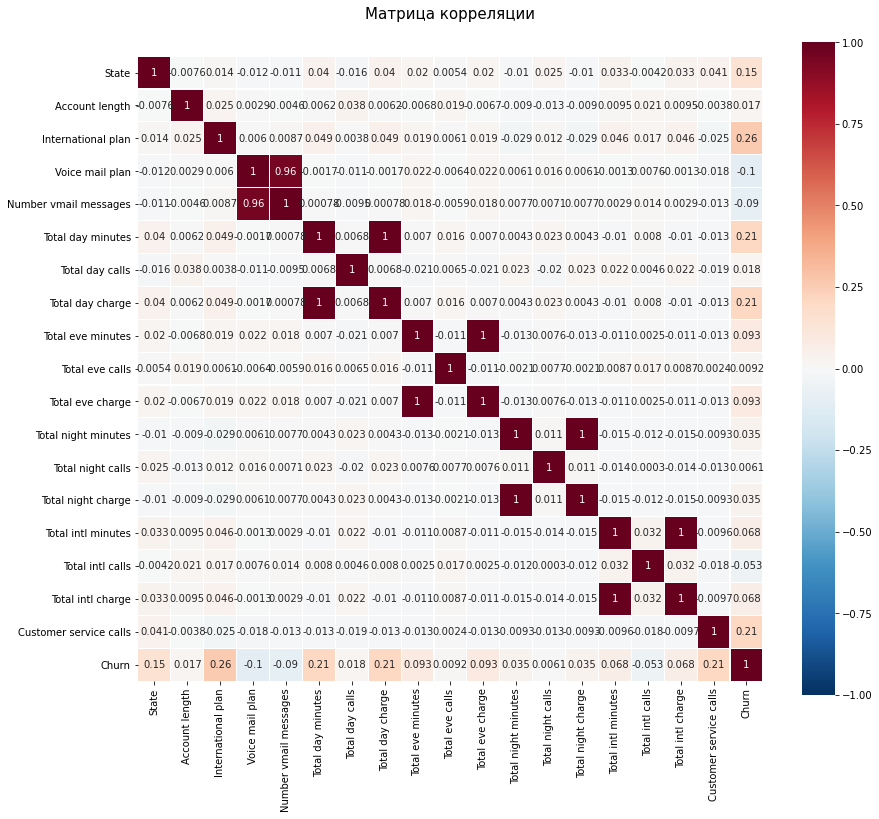

In [12]:
plt.figure(figsize=(14,12))
plt.title('Матрица корреляции', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, center=0,
            square=True, cmap=plt.cm.RdBu_r, linecolor='white', annot=True)
plt.show()

###  Приводим признаки к нормальному распределению

In [13]:
def analyze(data, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=60)
    plt.title(title, y=1.01, fontsize=14)
    plt.show()
    print('mean : ', np.mean(data))
    print('var  : ', np.var(data))
    print('skew : ', skew(data))
    print('kurt : ', kurtosis(data))
    print('shapiro : ', shapiro(data))
    print('normaltest : ', normaltest(data))

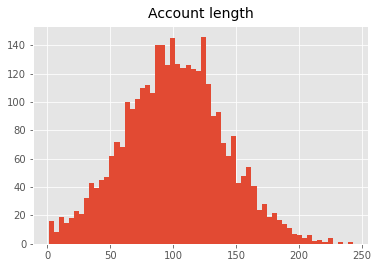

mean :  101.06480648064806
var  :  1585.3243329733511
skew :  0.09656281161489656
kurt :  -0.10947391843415755
shapiro :  ShapiroResult(statistic=0.9982772469520569, pvalue=0.0011495520593598485)
normaltest :  NormaltestResult(statistic=6.884425983113964, pvalue=0.03199380490776563)


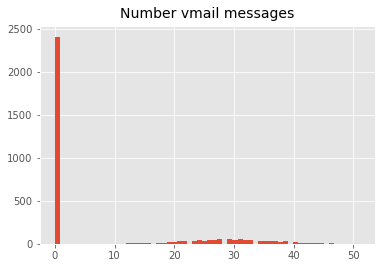

mean :  8.099009900990099
var  :  187.31512953275532
skew :  1.2642543349768245
kurt :  -0.05285151059052451
shapiro :  ShapiroResult(statistic=0.6219369769096375, pvalue=0.0)
normaltest :  NormaltestResult(statistic=556.3629445342845, pvalue=1.5392941776140257e-121)


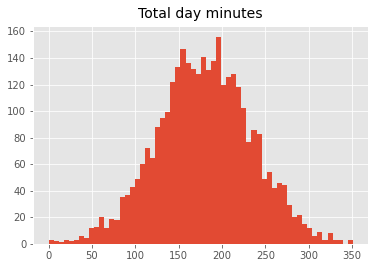

mean :  179.77509750975094
var  :  2965.8063885668494
skew :  -0.029063979518119797
kurt :  -0.021710117924088834
shapiro :  ShapiroResult(statistic=0.9995365738868713, pvalue=0.6374387741088867)
normaltest :  NormaltestResult(statistic=0.5096211575886979, pvalue=0.7750632974814358)


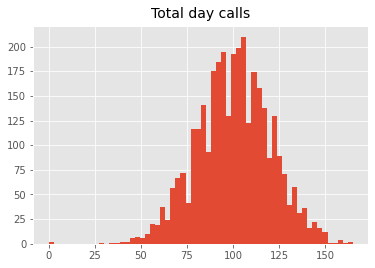

mean :  100.43564356435644
var  :  402.6472983932057
skew :  -0.11173632373075189
kurt :  0.24101722895174227
shapiro :  ShapiroResult(statistic=0.9979861974716187, pvalue=0.0002773392479866743)
normaltest :  NormaltestResult(statistic=13.75152737998376, pvalue=0.0010325088208268448)


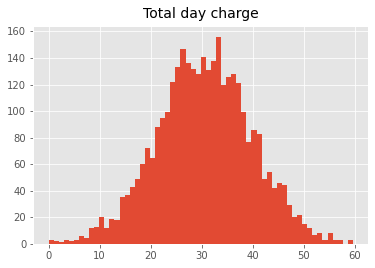

mean :  30.562307230723075
var  :  85.71140454767348
skew :  -0.02907017792703775
kurt :  -0.021581719145033595
shapiro :  ShapiroResult(statistic=0.9995384216308594, pvalue=0.641385018825531)
normaltest :  NormaltestResult(statistic=0.5092159606353127, pvalue=0.7752203400325994)


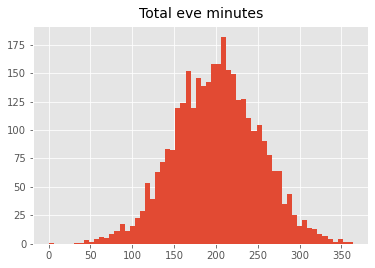

mean :  200.98034803480348
var  :  2571.122371075992
skew :  -0.023866708804637538
kurt :  0.0237916804447047
shapiro :  ShapiroResult(statistic=0.9995718598365784, pvalue=0.711155354976654)
normaltest :  NormaltestResult(statistic=0.4342080446809075, pvalue=0.8048462429604736)


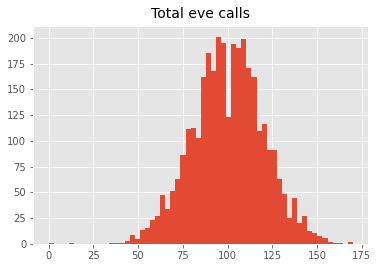

mean :  100.11431143114311
var  :  396.79191339475983
skew :  -0.05553813000161922
kurt :  0.20404769217448226
shapiro :  ShapiroResult(statistic=0.9986738562583923, pvalue=0.00886891596019268)
normaltest :  NormaltestResult(statistic=6.811357530792158, pvalue=0.03318428808943874)


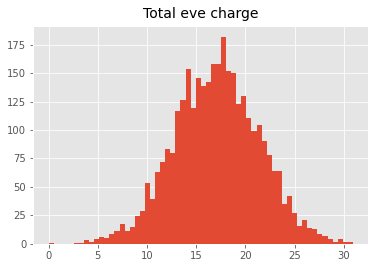

mean :  17.083540354035403
var  :  18.576280415188233
skew :  -0.023847250496276968
kurt :  0.02364954586272594
shapiro :  ShapiroResult(statistic=0.9995685815811157, pvalue=0.7044191360473633)
normaltest :  NormaltestResult(statistic=0.4325726682331947, pvalue=0.8055046253944554)


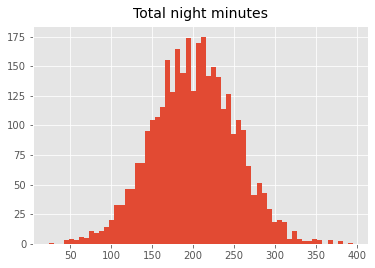

mean :  200.87203720372037
var  :  2556.9466108212982
skew :  0.008917275580987895
kurt :  0.08388775499253365
shapiro :  ShapiroResult(statistic=0.9995295405387878, pvalue=0.6227363348007202)
normaltest :  NormaltestResult(statistic=1.0757351051449409, pvalue=0.5839922583028743)


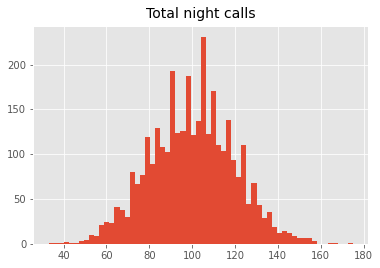

mean :  100.10771077107711
var  :  382.8155811080657
skew :  0.03248494205404463
kurt :  -0.07371122421258836
shapiro :  ShapiroResult(statistic=0.9993115067481995, pvalue=0.25032323598861694)
normaltest :  NormaltestResult(statistic=1.296432518261487, pvalue=0.5229778021474127)


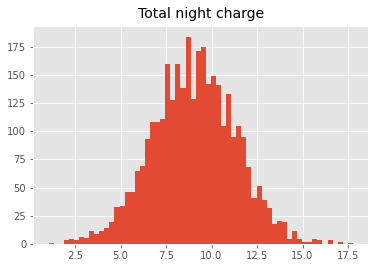

mean :  9.03932493249325
var  :  5.1780431386432975
skew :  0.008882237062694412
kurt :  0.08373508611499814
shapiro :  ShapiroResult(statistic=0.9995283484458923, pvalue=0.6202784180641174)
normaltest :  NormaltestResult(statistic=1.0720084566276888, pvalue=0.5850814396785253)


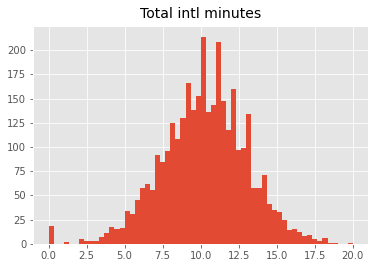

mean :  10.237293729372938
var  :  7.792029519783663
skew :  -0.24502560348664432
kurt :  0.606471635404318
shapiro :  ShapiroResult(statistic=0.9937329888343811, pvalue=8.136633727895415e-11)
normaltest :  NormaltestResult(statistic=64.21001941586222, pvalue=1.1401748114019145e-14)


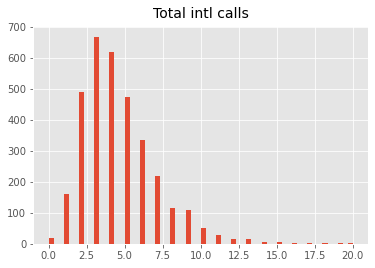

mean :  4.4794479447944795
var  :  6.055758231088635
skew :  1.3208833668164015
kurt :  3.0771654389888514
shapiro :  ShapiroResult(statistic=0.9057914018630981, pvalue=2.583573978675665e-41)
normaltest :  NormaltestResult(statistic=835.9852267335732, pvalue=2.9384245140168735e-182)


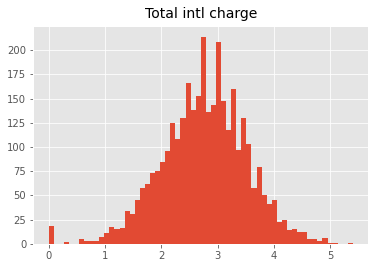

mean :  2.7645814581458144
var  :  0.5680026826084948
skew :  -0.24517610450098437
kurt :  0.6068966666527675
shapiro :  ShapiroResult(statistic=0.9937072992324829, pvalue=7.591647449567418e-11)
normaltest :  NormaltestResult(statistic=64.28330348321425, pvalue=1.0991526450917466e-14)


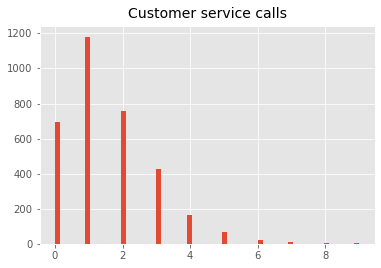

mean :  1.5628562856285628
var  :  1.7299974821964648
skew :  1.090868260175501
kurt :  1.7265184753957081
shapiro :  ShapiroResult(statistic=0.8767161965370178, pvalue=1.401298464324817e-45)
normaltest :  NormaltestResult(statistic=584.1773154131287, pvalue=1.404454686107752e-127)


In [14]:
unnecessary_cols = ['State', 'International plan',
                    'Voice mail plan', 'Churn']
cols_to_analyze = [x for x in list(df.columns) if x not in unnecessary_cols]
for i in cols_to_analyze:
    analyze(df[i].values, i)

Будем считать, что признаки, у которых skew > 0.75, или kurt > 0.75, или shapiro < $10^-5$ – сильно далеки от нормального распределения. Customer service calls подходит под это определение, однако мы не будем его трансформировать, так как тогда сильно падает корреляция этого признака.

In [15]:
bad_features = ['Number vmail messages', 'Total intl minutes',
                'Total intl calls', 'Total intl charge']

In [16]:
yeo_johnson_transform = PowerTransformer(method='yeo-johnson', standardize=False)
for feature in bad_features:
    df[feature + ' yeo johnson'] = yeo_johnson_transform.fit_transform(df[feature].values.reshape(df.shape[0],-1))

In [17]:
df_normalized = df.drop(bad_features, axis=1)
df = df[df.columns[:-4]]
df_normalized.head()

,State,Account length,International plan,Voice mail plan,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Customer service calls,Churn,Number vmail messages yeo johnson,Total intl minutes yeo johnson,Total intl calls yeo johnson,Total intl charge yeo johnson
0,3,128,0,1,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,1,0,1.042542,15.324847,1.521895,3.569697
1,1,107,0,1,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,1,0,1.044457,22.392807,1.521895,5.203943
2,3,137,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,0,0,-0.000000,19.465415,2.022525,4.517823
3,1,84,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,2,0,-0.000000,9.343981,2.394410,2.194421
4,2,75,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,3,0,-0.000000,15.508817,1.521895,3.616731


### Работа с разбалансированностью датасета

In [5]:
print('Форма датасета:', df.shape)
print('Баланс классов:', dict(df.Churn.value_counts()))
print('Доля каждого класса:', (dict(df.Churn.value_counts(normalize=True))))

Форма датасета: (3333, 19)
Баланс классов: {0: 2850, 1: 483}
Доля каждого класса: {0: 0.8550855085508551, 1: 0.14491449144914492}


In [6]:
y_train = df.Churn
X_train = df.drop('Churn', axis=1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

In [7]:
undersampler = RandomUnderSampler(random_state=27)
oversampler = RandomOverSampler(random_state=27)
smote = SMOTE(random_state=27)

In [8]:
best_clf = BestClassifier(X_std, y_train)
best_clf_undersampled = BestClassifier(X_std, y_train, undersampler)
best_clf_oversampled = BestClassifier(X_std, y_train, oversampler)
best_clf_smote = BestClassifier(X_std, y_train, smote)

#### Undersampling and oversampling with Random Forest

Best score (roc_auc): 0.9243545208597095
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 40}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9543968530808551
Balanced accuracy:  0.8581255010283143
Recall:  0.7225672877846792
Precision:  0.9509705257615406
F1:  0.8198458969085544
Roc_AUC:  0.9161654139275622
Confusion Matrix:
     0   1
0  405   3
1   20  49


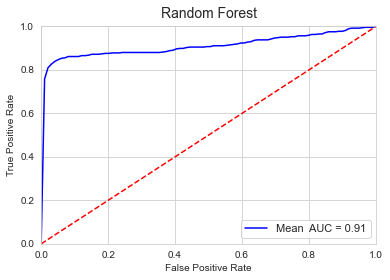

In [9]:
best_clf.random_forest()

Best score (roc_auc): 0.9154164405860012
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.8854025887084395
Balanced accuracy:  0.8676508179385417
Recall:  0.8426501035196688
Precision:  0.5778416688838338
F1:  0.6833892764573696
Roc_AUC:  0.9068999310367597
Confusion Matrix:
     0   1
0  363  44
1   10  59


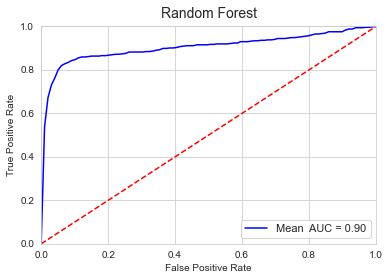

In [10]:
best_clf_undersampled.random_forest()

Best score (roc_auc): 0.9225842150479291
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 40}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9522966419272112
Balanced accuracy:  0.889568908430801
Recall:  0.8012422360248449
Precision:  0.860702959598415
F1:  0.8292157380114552
Roc_AUC:  0.9131022650843622
Confusion Matrix:
     0   1
0  397  10
1   14  55


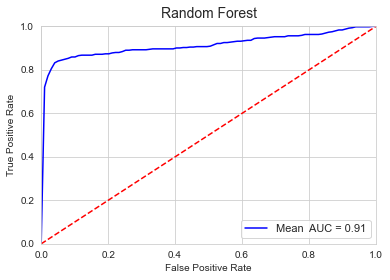

In [11]:
best_clf_oversampled.random_forest()

#### Oversampling and SMOTE with SVM

Best score (roc_auc): 0.9153125565201663
Best parameters: {'C': 3, 'class_weight': None, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9378959130822142
Balanced accuracy:  0.819245460709655
Recall:  0.6521739130434783
Precision:  0.890045653408187
F1:  0.7514727750390847
Roc_AUC:  0.9114222087367868
Confusion Matrix:
     0   1
0  402   6
1   24  45


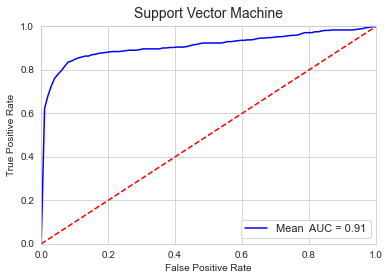

In [13]:
best_clf.svm()

Best score (roc_auc): 0.9089424700066318
Best parameters: {'C': 0.5, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9036954404403271
Balanced accuracy:  0.8611512145719307
Recall:  0.8012422360248447
Precision:  0.6359267036245425
F1:  0.7076125037551572
Roc_AUC:  0.9057941839271763
Confusion Matrix:
     0   1
0  375  32
1   14  55


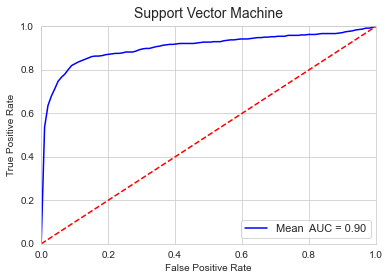

In [15]:
best_clf_oversampled.svm()

Best score (roc_auc): 0.904551682040152
Best parameters: {'C': 0.5, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

С лучшими параметрами и кросс-валидацией:
Accuracy:  0.9117942774594116
Balanced accuracy:  0.8486914875981373
Recall:  0.7598343685300206
Precision:  0.6746984462173149
F1:  0.7138639327711438
Roc_AUC:  0.9014935069922282
Confusion Matrix:
     0   1
0  382  25
1   17  52


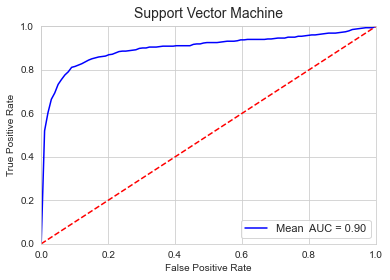

In [16]:
best_clf_smote.svm()

### Стекинг лучших моделей без ресемплинга данных

In [9]:
random_forest = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=11, n_estimators=40)
svmclf = svm.SVC(C=3, class_weight=None, degree=1, gamma='auto', kernel='rbf', probability=True)

ensemble = VotingClassifier(estimators=[('random_forest', random_forest), ('svmclf', svmclf)],
                            voting='soft', weights=[1,1])
ensemble.fit(X_std, y_train)

Accuracy:  0.9492979581769816
Balanced accuracy:  0.8405275874905032
Recall:  0.6873706004140786
Precision:  0.9489251675652021
F1:  0.7957376969087843
Roc_AUC:  0.9173419608202215
Confusion Matrix:
     0   1
0  404   3
1   21  48


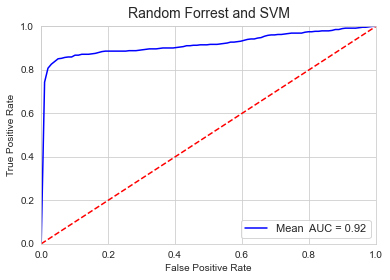

In [23]:
value_of_metrics_cv(X_std, y_train, ensemble, 'Random Forrest and SVM')

**Вывод:** для данной задачи лучшие результаты дал стекинг разных моделей без ресемплинга данных. Однако, если речь идет о том, что нам важно найти максимальное количество всех, кто перестанет пользоваться услугами компании (Churn==1), то лучше всего произвести undersampling данных и построить Random Forest, такая модель дает самый высокий recall (почти 85%).

In [12]:
import pickle

In [13]:
pickle.dump(ensemble, open('ensemble.pkl','wb'))